## LSTM Model with Unidirectional Forward Propagation

- In this part of the project, the focus is on implementing a Long Short-Term Memory (LSTM) model with unidirectional forward propagation to predict stock prices. LSTM is a type of recurrent neural network (RNN) that excels in learning from sequential data, making it well-suited for time series prediction tasks like forecasting stock prices.

- The unidirectional forward propagation means that the model processes the stock data sequentially from past to future, learning from previous time steps to make predictions about the next. This approach captures the temporal dependencies in the stock price data, where the model is trained to recognize patterns in the data's past values to predict future outcomes.

- The LSTM model is typically designed to handle the vanishing gradient problem, which is common in traditional RNNs, by maintaining a memory of important features over time. This allows the model to learn and retain long-term dependencies in the time series data, improving its forecasting accuracy for stock prices.

In [1]:
# Install Matplotlib for plotting and data visualization
#!pip install matplotlib

# Install Seaborn, a high-level plotting library based on Matplotlib that provides more attractive chart styles
#!pip install seaborn
#!pip install statsmodels

In [2]:
# Import necessary libraries
import sys
import warnings
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Ignore warning messages (prevent displaying unnecessary warnings)
if not sys.warnoptions:
    warnings.simplefilter('ignore')

### Part 1: Data Preprocessing with MinMaxScaler

#### Purpose:
This part of the project focuses on data preprocessing, specifically normalizing the stock price data using the MinMaxScaler. The purpose is to scale the stock closing prices (from the 'visa_stocks.csv' dataset) into a range between 0 and 1. This step is crucial for training machine learning models like LSTM, as it helps to standardize the input features and prevent issues related to large value ranges during training.

#### Significance:
Normalization is an essential step in machine learning workflows, especially for algorithms like neural networks, which are sensitive to the scale of input data. By applying the MinMaxScaler to the stock closing prices, we ensure that the model can learn more effectively. Scaling the data ensures that all features are on a similar scale, which can lead to faster convergence and improved model performance. This part sets up the data for further use in LSTM-based time series predictions.


In [3]:
sns.set()  # Set Seaborn's default style
tf.compat.v1.random.set_random_seed(1234)  # Set random seed for reproducibility

# Read stock data file ('visa_stocks.csv')
df = pd.read_csv('visa_stocks.csv')

# Display the first 5 rows of the data to check its structure
print(df.head())

# Use MinMaxScaler to normalize the closing price (Close index)
# Step 1: Extract the 5th column (index starts from 0, so it's the 4th column) as a specific type (float32) and fit the scaler
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))  # Closing price (Close index)

# Step 2: Apply the fitted scaler to the closing price data for transformation
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))  # Closing price (Close index)

# Convert the normalized data into DataFrame format for easier further processing
df_log = pd.DataFrame(df_log)

# Output the first 5 rows of the normalized data to check the result
print(df_log.head())

         Date       Open       High      Low    Close  Adj Close     Volume
0  2008-03-19  14.875000  17.250000  13.7500  14.1250  12.579995  708486000
1  2008-03-20  14.600000  16.250000  14.3750  16.0875  14.327834  198985200
2  2008-03-24  16.809999  16.924999  14.7500  14.9325  13.299167  149566400
3  2008-03-25  15.145000  16.062500  14.9550  15.8125  14.082910   87092000
4  2008-03-26  15.682500  16.120001  15.3925  15.9900  14.240999   43111600
          0
0  0.012529
1  0.019514
2  0.015403
3  0.018535
4  0.019167


### Part 2: Dataset Splitting

#### Purpose:
This part of the project splits the preprocessed dataset into training and test sets. The training set contains all the data except for the last 30 samples, while the test set consists of the last 30 samples. The purpose of this step is to prepare the data for model training and evaluation, ensuring that the model is trained on a separate set of data and tested on unseen data to assess its generalization ability.

#### Significance:
Splitting the data into training and test sets is a critical step in building a machine learning model. The training set is used to teach the model how to make predictions, while the test set serves as an unseen dataset to evaluate the model's performance. This separation helps prevent overfitting and ensures that the model's accuracy reflects its ability to generalize to new data. By defining a test set size and simulation size, the experiment ensures that


In [4]:
# Define the test set size and simulation size
test_size = 30  # The test set contains 30 samples
simulation_size = 10  # Number of simulation runs

# Split the normalized dataset into training and test sets
df_train = df_log.iloc[:-test_size]  # Training set: from the beginning of the data to the last 30 samples (excluding the last 30)
df_test = df_log.iloc[-test_size:]  # Test set: the last 30 samples

# Output the shape of the entire dataset, as well as the shapes of the training and test sets
df.shape, df_train.shape, df_test.shape

((4177, 7), (4147, 1), (30, 1))

### Part 3: Model Definition and Training

#### Purpose:
This part defines a custom neural network model for predicting stock prices using Long Short-Term Memory (LSTM) layers. The `Model` class is designed with flexibility in mind, allowing different configurations of layers, input sizes, and output sizes. The forward pass of the model (`call`) processes input data, while the `train_step` function performs one training iteration by calculating the gradients and updating the model's parameters. The model also incorporates dropout to mitigate overfitting. Additionally, a function to calculate accuracy and another function for smoothing the predicted signal are defined to evaluate and refine predictions.

#### Significance:
The purpose of this model is to provide an efficient framework for training a predictive model using LSTM layers, which are well-suited for sequential data like stock prices. By defining the training steps and loss function, the model can be trained on historical stock data to make future predictions. The accuracy function helps quantify the model's performance by evaluating how closely its predictions match the actual data. The signal smoothing function (anchor) improves the stability of the model’s predictions by reducing volatility, enhancing the interpretability of results. This approach is important for applications such as financial forecasting, where precise and stable predictions are crucial.


In [5]:
# Define a neural network model class
class Model:
    def __init__(
        self,
        learning_rate,   # Learning rate
        num_layers,      # Number of LSTM layers
        size,            # Size of the input features
        size_layer,      # Number of units in each LSTM layer
        output_size,     # Size of the output features
        forget_bias=0.1, # Forget gate retention rate (dropout keep probability)
    ):
        # Use Keras Sequential model to build the network
        self.model = tf.keras.Sequential()
        
        # Add LSTM layers
        for _ in range(num_layers):
            self.model.add(
                LSTM(size_layer, return_sequences=True, stateful=False)  # LSTM layer
            )
        
        # Add Dropout layer to avoid overfitting
        self.model.add(Dropout(1 - forget_bias))
        
        # Add a Dense layer for the output
        self.model.add(Dense(output_size))
        
        # Define the optimizer and loss function
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)  # Adam optimizer
        self.loss_fn = tf.keras.losses.MeanSquaredError()         # Mean squared error loss function
    
    # Define the forward pass of the model
    def call(self, X):
        return self.model(X)

    # Define a single training step
    def train_step(self, X, Y):
        with tf.GradientTape() as tape:  # Automatic differentiation
            logits = self.call(X)        # Compute predictions through the model
            loss = self.loss_fn(Y, logits)  # Compute the loss
        # Calculate gradients and update model parameters
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return logits, loss  # Return predictions and loss

# Define a function to calculate prediction accuracy
def calculate_accuracy(real, predict):
    real = np.array(real) + 1       # Add 1 to real values to avoid division by zero
    predict = np.array(predict) + 1 # Add 1 to predicted values
    # Calculate percentage error and convert it to accuracy
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100         # Return accuracy as a percentage

# Define a signal smoothing function
def anchor(signal, weight):
    buffer = []     # Buffer to store smoothed signal
    last = signal[0]  # Initialize with the first value of the signal
    for i in signal:
        # Apply weighted formula to smooth the signal
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)  # Add smoothed value to the buffer
        last = smoothed_val          # Update the last value
    return buffer  # Return the smoothed signal


### Part 4: Hyperparameter Setup

#### Purpose:
In this section, the hyperparameters for the LSTM model are defined to control the training process and model architecture. These hyperparameters include the number of LSTM layers (`num_layers`), the size of the hidden layer (`size_layer`), the length of the input sequence (`timestamp`), the number of training epochs (`epoch`), the dropout rate (`dropout_rate`), the number of days to predict (`future_day`), and the learning rate (`learning_rate`). These parameters are essential for fine-tuning the model's performance and determining how the model will process the data and adjust during training.

#### Significance:
The significance of setting appropriate hyperparameters is crucial for achieving optimal model performance. The number of LSTM layers and units per layer influences the model’s ability to capture complex temporal patterns in the data. The `timestamp` defines the temporal context of the input sequence, affecting how much past information the model uses to make predictions. The `dropout_rate` helps prevent overfitting by randomly "dropping" a percentage of neurons during training. The `epoch` controls the duration of training, determining how many times the model will be exposed to the data. The learning rate controls how quickly the model adjusts its parameters during training, which is critical for convergence and preventing overshooting. Setting these hyperparameters correctly allows the model to efficiently learn from the training data and make accurate predictions for future stock prices.


In [6]:
# Set the hyperparameters for the model
num_layers = 1           # Number of LSTM layers
size_layer = 128         # Number of units in each LSTM layer (size of the hidden layer)
timestamp = 5            # Time steps (length of the input sequence)
epoch = 10               # Number of training iterations (epochs)
dropout_rate = 0.8       # Retention rate of the Dropout layer (to prevent overfitting)
future_day = test_size   # Number of future days to predict, equal to the size of the test set
learning_rate = 0.01     # Learning rate, controls the step size for the optimizer's parameter updates

### Part 5: Model Training and Prediction Workflow

#### Purpose:
In this part, we define a series of functions to orchestrate the entire process of creating, training, and predicting with the LSTM model. 

1. **`create_model`**: Initializes and returns a new instance of the neural network model using the hyperparameters defined earlier, including the learning rate, number of LSTM layers, and other architectural settings.
   
2. **`train_model`**: Trains the model using the training data (`df_train`) over multiple epochs. The model is updated using the backpropagation process, where the loss is calculated at each step, and the model parameters are updated accordingly.

3. **`predict`**: Once the model is trained, this function predicts future values based on the trained model, using the last known values from the training dataset and applying the anchor function to smooth predictions. It returns the predicted values for the future days and the updated list of dates.

4. **`forecast`**: This function combines all the previous functions to create the model, train it, and use it to predict future values. It outputs the predicted values for the future days.

The overall goal is to train the model on historical data and forecast future values, which can be used for applications like stock price prediction, demand forecasting, or any time-series prediction task.

#### Significance:
This section is crucial for building a complete machine learning pipeline that not only trains the model but also makes predictions based on the trained model. By creating, training, and then forecasting with the model, this workflow can be applied to various time-series problems. The use of LSTM layers enables the model to capture long-term dependencies and trends in sequential data, which is often essential in fields like financial forecasting, weather prediction, and sales forecasting. The smooth predictions (using the `anchor` function) further improve the model's robustness by reducing noise and making the forecast more reliable.


In [7]:
def create_model():
    """
    Create and return an instance of the neural network model.

    This function initializes the model with the parameters specified for the LSTM layers, 
    dropout rate, learning rate, and other hyperparameters. It then returns the created model.

    Returns:
    Model: A Keras model instance ready for training.
    """
    # Initialize the model with the hyperparameters
    return Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )

def train_model(modelnn, df_train, epoch, timestamp):
    """
    Train the model using the training dataset for a given number of epochs.

    This function iterates through the dataset for a specified number of epochs, 
    processes the data in batches based on the timestamp (time window), 
    and updates the model parameters using backpropagation.

    Parameters:
    modelnn (Model): The neural network model that will be trained.
    df_train (DataFrame): The dataset used for training the model.
    epoch (int): The number of epochs (iterations) to train the model.
    timestamp (int): The length of each time sequence (number of time steps in the input).

    Returns:
    None
    """
    # Use tqdm to display a progress bar for training
    pbar = tqdm(range(epoch), desc='train loop')
    for _ in pbar:
        # Initialize lists to track total loss and accuracy for each epoch
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            # Define the end of the current batch window
            index = min(k + timestamp, df_train.shape[0] - 1)
            # Prepare the input batch (X) and the target output batch (Y)
            batch_x = np.expand_dims(df_train.iloc[k:index, :].values, axis=0)
            batch_y = df_train.iloc[k + 1:index + 1, :].values

            # Perform a single training step, getting the predictions and loss
            logits, loss = modelnn.train_step(batch_x, batch_y)
            # Store the loss and the calculated accuracy for each batch
            total_loss.append(loss.numpy())
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))

        # Update the progress bar with the current average loss and accuracy
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))

def predict(modelnn, df_train, future_day, timestamp, date_ori):
    """
    Use the trained model to make predictions for future days.

    This function first makes predictions on the training data, then it predicts 
    future data points based on the last known values from the training set.
    The predictions are smoothed using the anchor function.

    Parameters:
    modelnn (Model): The trained model to be used for predictions.
    df_train (DataFrame): The training dataset used for making predictions.
    future_day (int): The number of future days to predict.
    timestamp (int): The length of each time sequence for input.
    date_ori (list): The list of dates corresponding to the data for tracking predictions.

    Returns:
    tuple: A tuple containing the predicted values and the updated list of dates.
    """
    # Initialize the prediction array with zeros
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    # The first prediction is set to be the first row from the training data
    output_predict[0] = df_train.iloc[0].values
    # The variable upper_b is used to determine how much of the dataset will be predicted in chunks
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    init_value = np.zeros((1, num_layers * 2 * size_layer))  # Reset hidden state for LSTM
    # Perform prediction on the training set first
    for k in range(0, upper_b, timestamp):
        batch_x = np.expand_dims(df_train.iloc[k:k + timestamp, :].values, axis=0)
        logits = modelnn.call(batch_x)
        # Store the predicted logits in the output array
        output_predict[k + 1:k + timestamp + 1] = logits.numpy()

    # Handle any remaining data points after the chunk-based predictions
    if upper_b != df_train.shape[0]:
        batch_x = np.expand_dims(df_train.iloc[upper_b:, :].values, axis=0)
        logits = modelnn.call(batch_x)
        output_predict[upper_b + 1:df_train.shape[0] + 1] = logits.numpy()
        # Update the number of future days to predict and append the next date to date_ori
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))

    # Now, predict the future data points
    for i in range(future_day):
        # Prepare the previous predictions as input for the next prediction
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        batch_x = np.expand_dims(o, axis=0)
        logits = modelnn.call(batch_x)
        output_predict[-future_day + i] = logits.numpy()[-1, 0]
        # Append the next predicted date to the list
        date_ori.append(date_ori[-1] + timedelta(days=1))

    # Reverse the min-max scaling for the predicted values
    output_predict = minmax.inverse_transform(output_predict)
    # Apply smoothing to the predictions using the anchor function
    deep_future = anchor(output_predict[:, 0], 0.3)

    # Return the predicted future values and the updated list of dates
    return deep_future[-test_size:], date_ori  # Return the last 'test_size' predictions and the updated dates

def forecast():
    """
    Create, train, and use the model to make predictions for the future days.

    This function orchestrates the entire process: creating the model, 
    training it using the training data, and predicting the future data points.
    
    Returns:
    predicted_values (array): The predicted values for the future days based on the model.
    """
    # Create the model instance
    modelnn = create_model()

    # Train the model with the training data
    train_model(modelnn, df_train, epoch, timestamp)

    # Convert the first column of the dataset to datetime and create a list of dates
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    # Set the number of future days to predict (based on the test set size)
    future_day = test_size  
    # Make predictions for the future days using the trained model
    predicted_values, date_ori = predict(modelnn, df_train, future_day, timestamp, date_ori)
    
    # Return the predicted values for the future days
    return predicted_values


### Part 6: Perform Multiple Simulations of a Forecasting Model

#### Purpose:
The purpose of this code is to perform multiple simulations of a forecasting model. It loops through a specified number of simulations (`simulation_size`) and executes the forecasting process in each iteration. For each simulation, it records the forecast results and the time taken to complete the simulation. This enables the evaluation of the model's performance across multiple runs, providing insight into the model's consistency and efficiency.

#### Significance:
- **Model Evaluation**: By running multiple simulations, the model's performance can be assessed under different conditions, allowing for better generalization and reliability analysis. Observing the variation in results across runs helps to identify any inconsistencies or overfitting in the model.
  
- **Performance Metrics**: Recording the duration of each simulation provides valuable data on the computational efficiency of the model. This can be helpful for determining the scalability of the model and optimizing the training or forecasting process.
  
- **Scalability and Robustness**: Running multiple simulations with varying data can help evaluate the robustness of the model, ensuring it performs well not just on a single set of data but across various scenarios, making it more reliable for real-world applications.


In [8]:
# Initialize an empty list to store the results of each simulation's forecast
results = []

# Initialize an empty list to store the duration of each simulation run (in seconds)
simulation_times = []

# Start a loop to run multiple simulations (simulation_size defines how many times to run)
for i in range(simulation_size):
    start_time = time.time()  # Record the current time as the start time of the simulation
    print(f"simulation {i + 1} started")  # Print a message indicating the start of the simulation

    # Call the forecast() function to perform the forecast and store the result in forecast_result
    forecast_result = forecast()

    # Append the forecast result to the results list for later use or analysis
    results.append(forecast_result)

    end_time = time.time()  # Record the current time as the end time of the simulation
    simulation_duration = end_time - start_time  # Calculate the time it took to complete this simulation (in seconds)

    # Append the simulation duration to the simulation_times list for later analysis
    simulation_times.append(simulation_duration)

    # Print a message indicating that the simulation has completed, along with the time it took to run
    print(f"simulation {i + 1} completed in {simulation_duration:.2f} seconds")


simulation 1 started


train loop: 100%|██████| 10/10 [01:12<00:00,  7.21s/it, acc=99.3, cost=0.000184]


simulation 1 completed in 74.66 seconds
simulation 2 started


train loop: 100%|██████| 10/10 [01:11<00:00,  7.17s/it, acc=99.1, cost=0.000225]


simulation 2 completed in 74.21 seconds
simulation 3 started


train loop: 100%|██████| 10/10 [01:11<00:00,  7.19s/it, acc=99.3, cost=0.000191]


simulation 3 completed in 74.49 seconds
simulation 4 started


train loop: 100%|██████| 10/10 [01:12<00:00,  7.20s/it, acc=99.2, cost=0.000213]


simulation 4 completed in 74.58 seconds
simulation 5 started


train loop: 100%|██████| 10/10 [01:12<00:00,  7.24s/it, acc=99.1, cost=0.000211]


simulation 5 completed in 74.96 seconds
simulation 6 started


train loop: 100%|██████| 10/10 [01:11<00:00,  7.17s/it, acc=99.3, cost=0.000187]


simulation 6 completed in 74.24 seconds
simulation 7 started


train loop: 100%|███████| 10/10 [01:12<00:00,  7.22s/it, acc=98.6, cost=0.00071]


simulation 7 completed in 74.72 seconds
simulation 8 started


train loop: 100%|██████| 10/10 [01:11<00:00,  7.16s/it, acc=99.3, cost=0.000182]


simulation 8 completed in 74.19 seconds
simulation 9 started


train loop: 100%|███████| 10/10 [01:11<00:00,  7.16s/it, acc=99.1, cost=0.00022]


simulation 9 completed in 74.26 seconds
simulation 10 started


train loop: 100%|██████| 10/10 [01:11<00:00,  7.19s/it, acc=99.2, cost=0.000214]


simulation 10 completed in 74.43 seconds


### Part 7: Data Visualization

#### Purpose:
The purpose of this code is to evaluate and visualize the accuracy of multiple forecast results compared to the actual closing prices of a stock. After calculating the accuracy of each forecast, it plots both the forecasted stock prices and the true stock price trend. The plot also includes a title displaying the average accuracy of all forecasts, which provides a visual comparison of the model’s prediction accuracy over multiple simulations.

#### Significance:
- **Accuracy Assessment**: By calculating the accuracy of each forecast compared to the true closing prices, the code provides a quantitative evaluation of the forecasting model's performance. This allows for a clear understanding of how well the model can predict future stock prices and whether it is suitable for real-world applications.

- **Model Comparison**: Plotting multiple forecast results on the same graph allows for an easy comparison of different forecasts generated in the simulations. This comparison helps to identify patterns, trends, or discrepancies in the model's predictions, guiding further refinement or adjustment of the model.

- **Visual Representation**: The plot offers a clear visual representation of the stock price trends, helping stakeholders, analysts, or data scientists to visually assess the model's predictive power. Including the true stock price trend in red provides a benchmark for performance evaluation, making it easier to interpret how closely the model’s forecasts match the actual data.

- **Model Improvement**: The average accuracy displayed in the title of the plot provides an overall measure of the model’s effectiveness across simulations, offering valuable insights for improving the model. If the accuracy is not satisfactory, it indicates the need for model adjustments or additional feature engineering to enhance prediction accuracy.


# Plots

## Plot 1: Comparison of Forecasted Stock Prices vs. True Trend with Accuracy Evaluation

**Purpose:**  
To compare the forecasted stock price trends from multiple simulations against the actual true stock price trend and visualize the accuracy of each forecast. The plot aims to evaluate how well the forecasted trends match the true stock prices over the test period.

**Significance:**  
This visualization provides insight into the performance of the forecast model(s) and the reliability of predictions. By plotting the forecast results alongside the true stock prices, it allows for a clear visual comparison and quantifies the accuracy of each forecast, which can inform decisions regarding the effectiveness of the forecasting model.

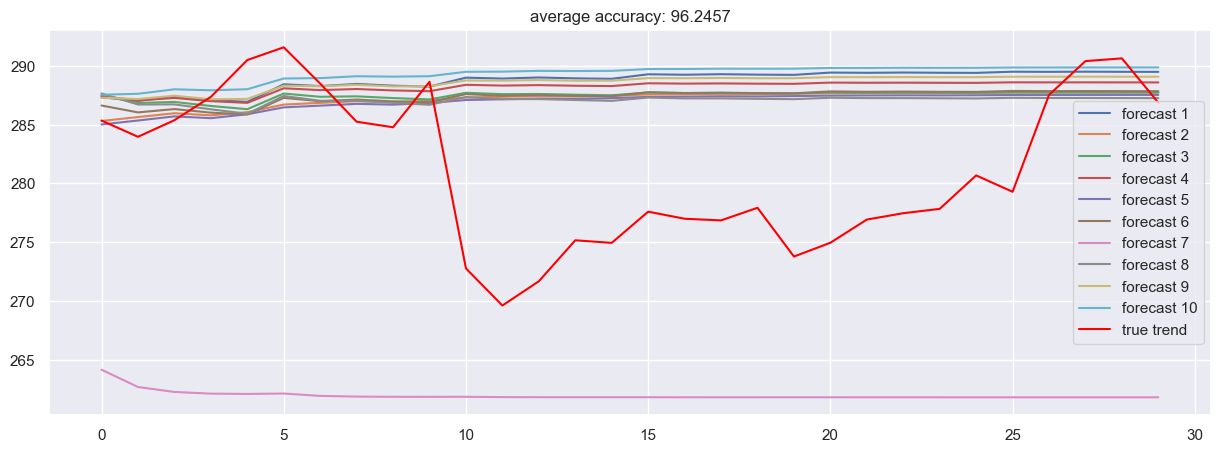

In [9]:
# Calculate the accuracy of each forecast result compared to the true closing prices
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

# Create a plot with a size of 15x5 inches
plt.figure(figsize = (15, 5))

# Plot each forecast result with a label indicating its forecast number
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d' % (no + 1))

# Plot the true stock price trend in red
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'red')

# Display the legend to label each line in the plot
plt.legend()

# Set the plot title with the average accuracy of all forecasts
plt.title('average accuracy: %.4f' % (np.mean(accuracies)))

# Display the plot
plt.show()

## Plot 2: True vs Predicted Stock Price

**Purpose:**  
To compare the true stock prices against the predicted stock prices for the last 'test_size' days, visually highlighting the accuracy of the forecast model over a specified period.

**Significance:**  
This plot serves to assess how closely the predicted stock prices align with the actual prices. By displaying both the true and predicted values, it provides a clear visual indication of the model's forecasting performance, helping to identify any discrepancies or trends in the predictions.


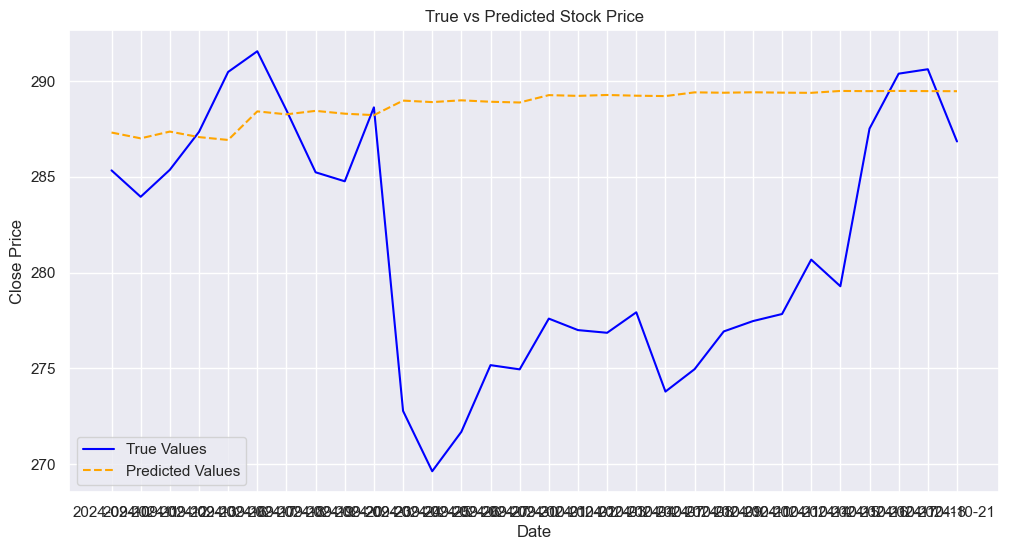

In [10]:
# Create a figure with a size of 12x6 inches
plt.figure(figsize=(12, 6))

# Plot the true values of the stock price for the last 'test_size' days with blue color
plt.plot(df['Date'][-test_size:], df['Close'][-test_size:], label='True Values', color='blue')

# Plot the predicted values of the stock price for the last 'test_size' days with orange color and dashed line style
plt.plot(df['Date'][-test_size:], results[0], label='Predicted Values', color='orange', linestyle='--')

# Set the title of the plot
plt.title('True vs Predicted Stock Price')

# Label the x-axis as 'Date'
plt.xlabel('Date')

# Label the y-axis as 'Close Price'
plt.ylabel('Close Price')

# Display the legend to identify true and predicted values
plt.legend()

# Display the plot
plt.show()

## Plot 3: Simulations of Forecast

**Purpose:**  
To display the results of multiple forecast simulations, highlighting the variation in predictions and showcasing the mean prediction along with the standard deviation at each time step. The plot allows for visualizing the spread and consistency of the forecast results.

**Significance:**  
This plot is important for assessing the uncertainty and variability in the model's predictions. By showing individual simulation results, the mean prediction, and the range defined by one standard deviation, it helps to understand the model's robustness and reliability in forecasting over time.


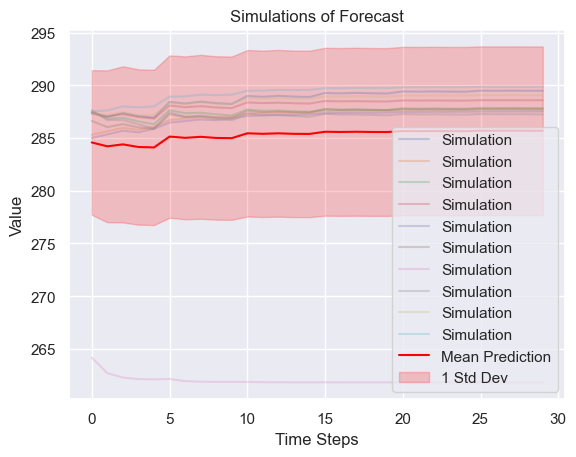

In [11]:
# Convert the list of prediction results to a NumPy array for easier computation
predictions_array = np.array(results)

# Calculate the mean of the predictions at each time step across all simulations
mean_result = np.mean(predictions_array, axis=0)

# Calculate the standard deviation of the predictions at each time step across all simulations
std_result = np.std(predictions_array, axis=0)

# Loop through each result in the simulation results and plot them with reduced opacity for distinction
for result in results:
    plt.plot(result, alpha=0.3, label='Simulation')  # Set transparency for distinguishing multiple simulations

# Plot the mean of the predictions as a red line
plt.plot(mean_result, color='red', label='Mean Prediction')

# Fill the area between mean - standard deviation and mean + standard deviation with red color and transparency
plt.fill_between(range(len(mean_result)), 
                 mean_result - std_result, 
                 mean_result + std_result, 
                 color='red', alpha=0.2, label='1 Std Dev')

# Add a legend to identify different plot elements
plt.legend()

# Set the title of the plot
plt.title('Simulations of Forecast')

# Label the x-axis as 'Time Steps'
plt.xlabel('Time Steps')

# Label the y-axis as 'Value'
plt.ylabel('Value')

# Display the plot
plt.show()


## Plot 4: True vs Predicted Values (Multiple Simulations)

**Purpose:**  
To compare the true stock prices with the mean of multiple forecast predictions, highlighting the accuracy of the model's predictions over time. The plot also includes a confidence interval based on the standard deviation of the predictions, providing a visual indication of uncertainty.

**Significance:**  
This plot is significant for evaluating how well the forecast model performs against real data, showing both the mean predicted values and the variability across different simulations. The confidence interval helps to assess the consistency of the predictions, giving insights into the model's reliability and uncertainty.


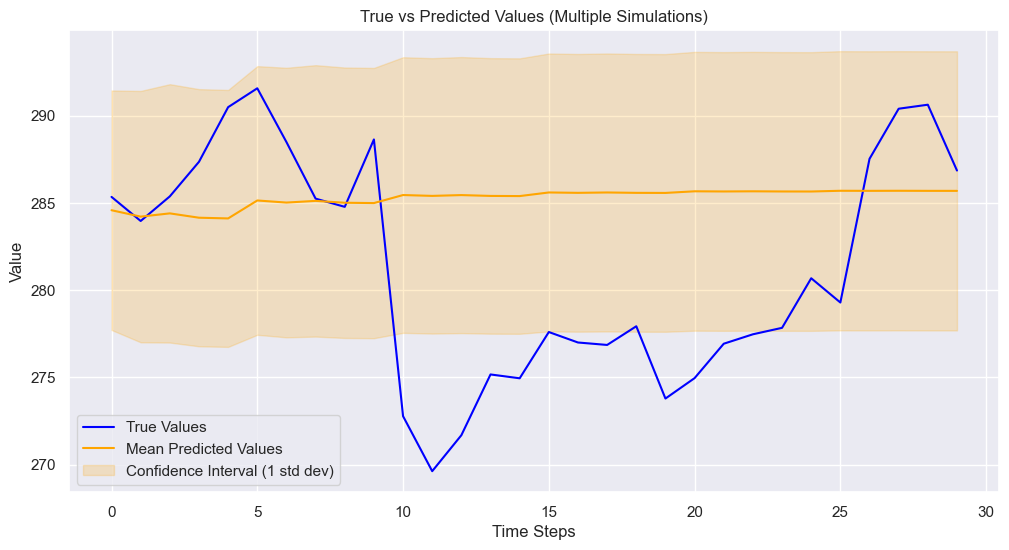

In [12]:
# Extract the true closing prices for the last 'test_size' number of steps
true_values = df['Close'].iloc[-test_size:].values

# Convert the list of prediction results to a NumPy array for easier computation
predictions_array = np.array(results)

# Calculate the mean of the predictions at each time step across all simulations
mean_prediction = np.mean(predictions_array, axis=0)

# Calculate the standard deviation of the predictions at each time step across all simulations
std_prediction = np.std(predictions_array, axis=0)

# Create a plot with a specified size
plt.figure(figsize=(12, 6))

# Plot the true values as a blue line
plt.plot(true_values, label='True Values', color='blue')

# Plot the mean predicted values as an orange line
plt.plot(mean_prediction, label='Mean Predicted Values', color='orange')

# Fill the area between the mean prediction minus standard deviation and the mean prediction plus standard deviation
# to represent the confidence interval with orange color and 20% transparency
plt.fill_between(range(len(mean_prediction)),
                 mean_prediction - std_prediction,
                 mean_prediction + std_prediction,
                 color='orange', alpha=0.2, label='Confidence Interval (1 std dev)')

# Set the title of the plot
plt.title('True vs Predicted Values (Multiple Simulations)')

# Label the x-axis as 'Time Steps'
plt.xlabel('Time Steps')

# Label the y-axis as 'Value'
plt.ylabel('Value')

# Display the legend to explain the plot labels
plt.legend()

# Show the plot
plt.show()


## Plot 5: Residuals Over Time

**Purpose:**  
To visualize the residuals (differences) between the true stock prices and the mean predicted values over time. This plot helps in assessing how well the forecast model is performing by examining the errors in the predictions at each time step.

**Significance:**  
This plot is significant for understanding the model's prediction accuracy. Residuals close to zero indicate that the model's predictions are accurate, while large deviations suggest poor model performance. The horizontal line at y=0 serves as a baseline, making it easier to identify systematic errors and trends in the residuals.


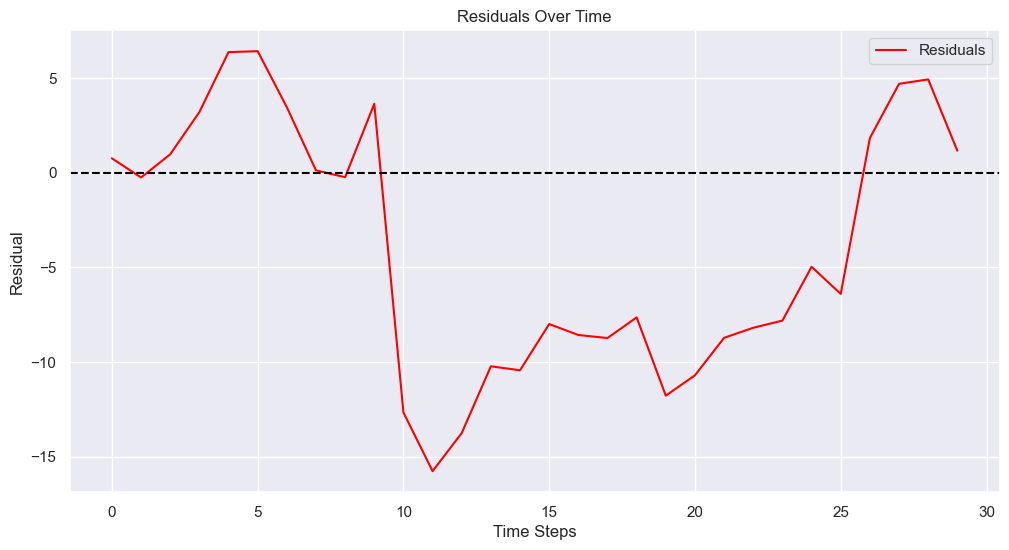

In [13]:
# Assign the mean predicted values to a variable for residual calculation
predicted_values = mean_prediction

# Calculate the residuals (differences between the true values and predicted values)
residuals = true_values - predicted_values

# Create a plot with a specified size
plt.figure(figsize=(12, 6))

# Plot the residuals as a red line
plt.plot(residuals, label='Residuals', color='red')

# Add a horizontal line at y=0 to represent the baseline for residuals (where the error is zero)
plt.axhline(y=0, color='black', linestyle='--')

# Set the title of the plot
plt.title('Residuals Over Time')

# Label the x-axis as 'Time Steps'
plt.xlabel('Time Steps')

# Label the y-axis as 'Residual'
plt.ylabel('Residual')

# Display the legend to explain the plot labels
plt.legend()

# Show the plot
plt.show()


## Plot 6: Residual Distribution

**Purpose:**  
To visualize the distribution of residuals (the differences between the true values and predicted values). The plot includes a histogram and a kernel density estimate (KDE), which helps in understanding the spread and underlying distribution of prediction errors.

**Significance:**  
This plot is significant for diagnosing the model's performance. A well-behaved residual distribution (e.g., centered around zero and normally distributed) indicates that the model's errors are randomly distributed, suggesting a good model fit. Conversely, any skewness or patterns in the residuals may suggest that the model has some bias or systematic errors.


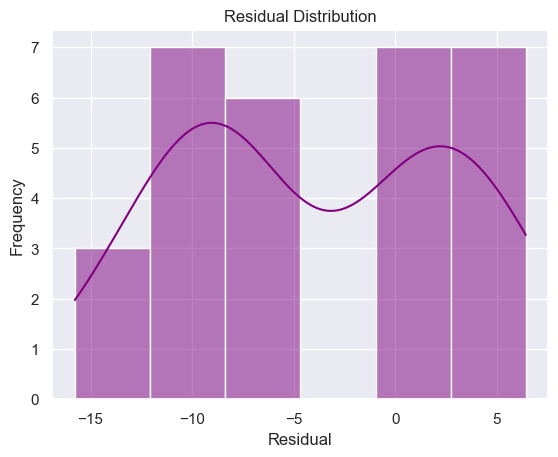

In [14]:
# Create a histogram with a kernel density estimate (KDE) for the residuals, using purple color
sns.histplot(residuals, kde=True, color='purple')

# Set the title of the plot
plt.title('Residual Distribution')

# Label the x-axis as 'Residual'
plt.xlabel('Residual')

# Label the y-axis as 'Frequency'
plt.ylabel('Frequency')

# Display the plot
plt.show()

## Plot 7: RMSE Over Time Steps

**Purpose:**  
To visualize the Root Mean Square Error (RMSE) at each time step across all simulations. RMSE provides an aggregate measure of the model's prediction error, helping to evaluate the model's accuracy over time.

**Significance:**  
This plot is significant for assessing the model's performance over the entire forecasting period. A lower RMSE indicates better accuracy in predictions, while higher RMSE values highlight time steps where the model's predictions deviate more from the true values. Tracking RMSE over time helps identify trends in model error, such as periods of higher or lower prediction accuracy.


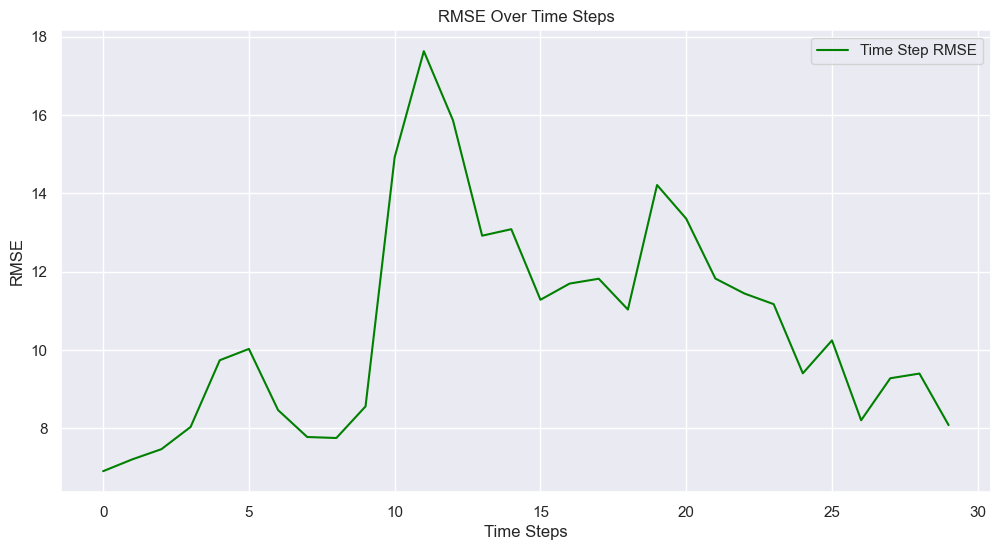

In [15]:
# Calculate the RMSE (Root Mean Square Error) for each time step
time_step_rmse = np.sqrt(np.mean((predictions_array - true_values)**2, axis=0))

# Create a figure for the plot with specified size
plt.figure(figsize=(12, 6))

# Plot the RMSE values over time steps, labeled as 'Time Step RMSE' and colored green
plt.plot(time_step_rmse, label='Time Step RMSE', color='green')

# Set the title of the plot
plt.title('RMSE Over Time Steps')

# Label the x-axis as 'Time Steps'
plt.xlabel('Time Steps')

# Label the y-axis as 'RMSE'
plt.ylabel('RMSE')

# Display the legend on the plot
plt.legend()

# Show the plot
plt.show()


## Plot 8: Autocorrelation and Partial Autocorrelation Plots

**Purpose:**  
To analyze the temporal dependencies in the stock price data by plotting the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) with 30 lags. The ACF helps to understand the overall correlation between the stock prices at different time lags, while the PACF identifies the direct relationship between the current and lagged values after removing the effects of intervening lags.

**Significance:**  
These plots are significant in identifying the underlying structure of the time series data. The ACF helps detect long-term dependencies in the data, which is useful for identifying trends and seasonal patterns. The PACF is particularly useful in identifying the order of autoregressive (AR) models when building time series forecasting models. Both ACF and PACF are essential tools for model selection and understanding the autocorrelations in stock price movements.


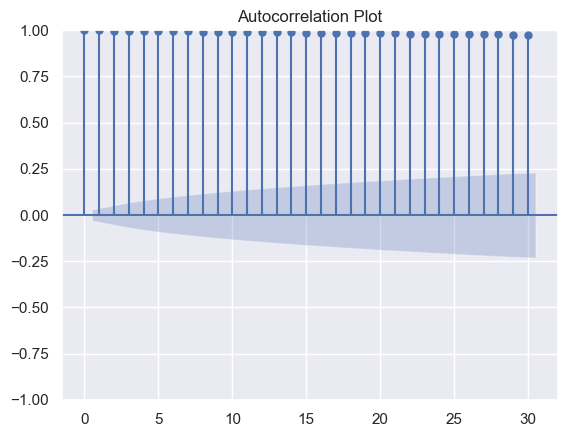

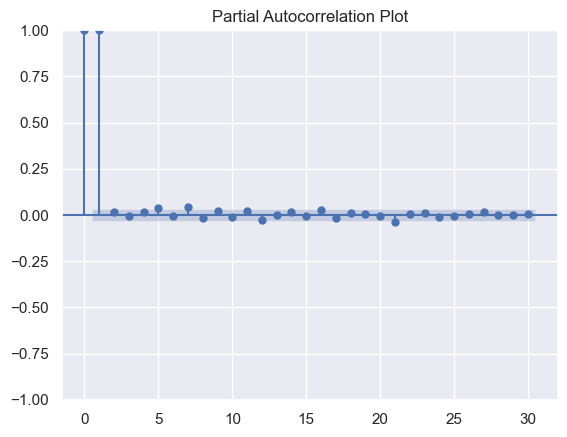

In [16]:
# Plot the Autocorrelation Function (ACF) for the 'Close' column with 30 lags
plot_acf(df['Close'], lags=30)

# Set the title for the Autocorrelation Plot
plt.title('Autocorrelation Plot')

# Display the Autocorrelation plot
plt.show()

# Plot the Partial Autocorrelation Function (PACF) for the 'Close' column with 30 lags
plot_pacf(df['Close'], lags=30)

# Set the title for the Partial Autocorrelation Plot
plt.title('Partial Autocorrelation Plot')

# Display the Partial Autocorrelation plot
plt.show()


## Plot 9: Smoothed Predicted vs True Stock Price

**Purpose:**  
To compare the smoothed predicted stock prices against the true stock prices. The smoothing technique applied to the predicted values helps reduce noise and make the forecast more stable, enabling a clearer comparison with the actual stock price trend.

**Significance:**  
This plot is significant because it demonstrates how smoothing can improve the clarity and accuracy of predictions, especially in volatile time series data like stock prices. By reducing the fluctuations in the predictions, the smoothed values provide a more reliable representation of future trends, helping to assess the model’s effectiveness and forecasting ability.


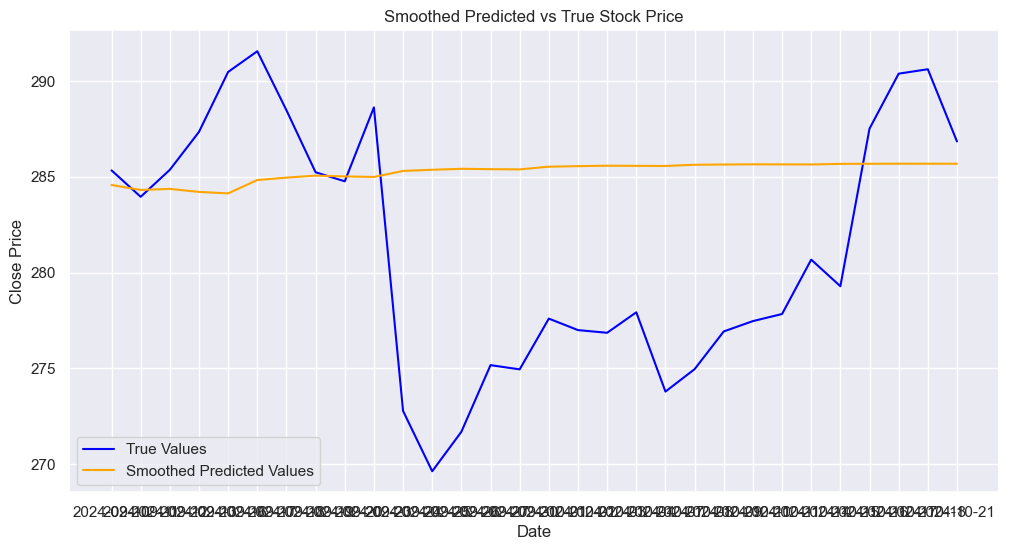

In [17]:
# Apply smoothing to the mean prediction using the anchor function with a smoothing factor of 0.3
smoothed_prediction = anchor(mean_prediction, 0.3)

# Create a figure for the plot with a size of 12x6 inches
plt.figure(figsize=(12, 6))

# Plot the true values ('Close') for the last 'test_size' dates, in blue
plt.plot(df['Date'][-test_size:], df['Close'][-test_size:], label='True Values', color='blue')

# Plot the smoothed predicted values for the last 'test_size' dates, in orange
plt.plot(df['Date'][-test_size:], smoothed_prediction, label='Smoothed Predicted Values', color='orange')

# Set the title of the plot
plt.title('Smoothed Predicted vs True Stock Price')

# Set the x-axis label as 'Date'
plt.xlabel('Date')

# Set the y-axis label as 'Close Price'
plt.ylabel('Close Price')

# Display the legend to differentiate between true values and smoothed predictions
plt.legend()

# Display the plot
plt.show()


## Plot 10: Daily Percentage Change (True vs Predicted)

**Purpose:**  
To compare the daily percentage changes in the true stock prices with the predicted percentage changes. This plot illustrates how well the model’s predictions capture the daily fluctuations in stock prices.

**Significance:**  
This plot is significant because it highlights the model's ability to track the dynamics of stock price movements. By comparing the true and predicted percentage changes, it provides insight into the model's accuracy in forecasting short-term price variations, which is essential for trading strategies and risk management. The rolling average also smooths out short-term volatility, helping to assess overall trend-following performance.

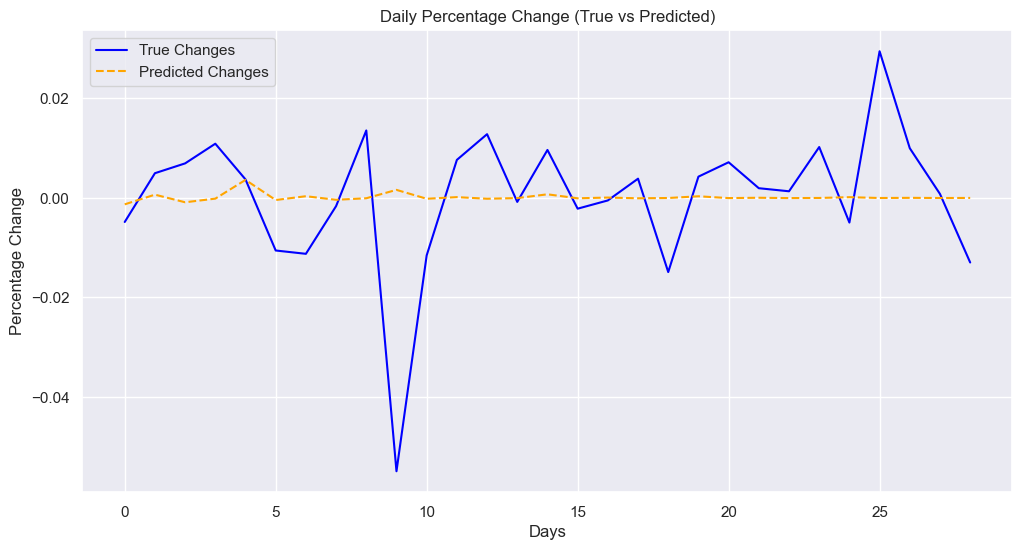

In [18]:
# Calculate the percentage changes in the true values of 'Close' for the last 'test_size' days
true_changes = np.diff(df['Close'][-test_size:]) / df['Close'][-test_size:][:-1]

# Calculate the percentage changes in the predicted values (mean prediction)
pred_changes = np.diff(mean_prediction) / mean_prediction[:-1]

# Compute the 7-day rolling average of the true changes using pandas rolling method
rolling_true = pd.Series(true_changes).rolling(window=7).mean()

# Compute the 7-day rolling average of the predicted changes using pandas rolling method
rolling_pred = pd.Series(pred_changes).rolling(window=7).mean()

# Create a figure for the plot with a size of 12x6 inches
plt.figure(figsize=(12, 6))

# Plot the true percentage changes (calculated earlier) with the x-axis representing the range of days and color it blue
plt.plot(range(len(true_changes)), true_changes, label='True Changes', color='blue')

# Plot the predicted percentage changes (calculated earlier) with the x-axis representing the range of days and color it orange with dashed lines
plt.plot(range(len(pred_changes)), pred_changes, label='Predicted Changes', color='orange', linestyle='--')

# Set the title of the plot
plt.title('Daily Percentage Change (True vs Predicted)')

# Set the x-axis label as 'Days'
plt.xlabel('Days')

# Set the y-axis label as 'Percentage Change'
plt.ylabel('Percentage Change')

# Display the legend to differentiate between true and predicted changes
plt.legend()

# Display the plot
plt.show()
